# Project 7 - Airport Delays and other problems

### Intro: Write a problem statement / aim for this project

We want to understand what factors are contributing to departure delays from airports.

Departure delays can cascade through the airport network because each each departure delay inluences the arrival delays at other airports.  There are many potential costs associated with delays, such as real time reallocation of resources, increased costs if flights attempt to compensate for departure delays by reducing flight time and seat reallocation for passengers that do not make connections during multi-leg flights.

Two potential models to consider for the airport network would be TCP/IP networks or a reactor system.  Creating these models is beyond the scope of the current project, but could provide insight for creating analytial models.  The current project will provide machine learning insghts.  The TCP/IP model could model each passenger as packet, a flioght as frame, the aiports as servers and the flight path/time as network cableing.  A reactor system could consider the "residence time" for each flight in an airport and the cost of exceeding the required residence time.

Initially, some of the "residence time" model will be used.  The target features describing the change of delay across and airport will be sought, then factors associated with that change will be sought.

### Import modules for use.

In [2]:
from sklearn.manifold import TSNE
import numpy as np
import yaml
import psycopg2
import pandas as pd

import sqlalchemy
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from scipy.stats.mstats import normaltest
from mpl_toolkits.mplot3d import Axes3D


import matplotlib.pyplot as plt
import seaborn as sns
import lib.renders as rs
from IPython.display import display


%matplotlib inline

In [3]:
#test for dependency problems with TSNE

temp = '5, 3, 23'
for i in range(1,5):
    for j in range(1,5):
        vec = "; {} {} {}".format(i/23., j/3.4, j**.3*i**.5)
        temp += vec
temp = np.matrix(temp)
print temp

[[  5.           3.          23.        ]
 [  0.04347826   0.29411765   1.        ]
 [  0.04347826   0.58823529   1.23114441]
 [  0.04347826   0.88235294   1.39038917]
 [  0.04347826   1.17647059   1.51571657]
 [  0.08695652   0.29411765   1.41421356]
 [  0.08695652   0.58823529   1.74110113]
 [  0.08695652   0.88235294   1.96630722]
 [  0.08695652   1.17647059   2.14354693]
 [  0.13043478   0.29411765   1.73205081]
 [  0.13043478   0.58823529   2.13240468]
 [  0.13043478   0.88235294   2.40822469]
 [  0.13043478   1.17647059   2.6252981 ]
 [  0.17391304   0.29411765   2.        ]
 [  0.17391304   0.58823529   2.46228883]
 [  0.17391304   0.88235294   2.78077834]
 [  0.17391304   1.17647059   3.03143313]]


In [4]:
tsn = TSNE(n_components=2)
tsn.fit_transform(temp)

array([[ -1.99120031e-05,  -9.73219133e-05],
       [ -2.62241087e-05,  -6.34297273e-05],
       [ -1.51022552e-04,   8.88623469e-06],
       [  3.59730058e-06,   9.04434172e-05],
       [ -8.90818538e-05,   5.65503359e-05],
       [ -8.79205102e-05,  -1.05494560e-04],
       [ -9.68217598e-05,   6.74196191e-05],
       [ -7.25569040e-05,  -8.38292188e-06],
       [ -6.00554892e-05,  -8.25453920e-05],
       [ -6.98967501e-05,   1.05422082e-04],
       [ -7.56880140e-05,   4.38649956e-05],
       [  1.38517689e-04,  -3.08052937e-05],
       [ -7.56062790e-05,   2.47299768e-05],
       [  1.06958152e-04,  -3.86072279e-05],
       [ -9.61025784e-05,  -9.98878013e-05],
       [  6.05369858e-05,  -2.41333813e-05],
       [ -5.65276105e-06,  -5.58420771e-05]])

### Import datafiles to pandas and Postgres.

Some of the information is not obivious from this code.  The server, user credentials and database name are hidden in a file called credentials.yaml.  

Also, the csv files provided are in the data directory.  These are all imported in the next step and written to the postgres database at the same time.

In [5]:
with open('data/credentials.yaml', 'r') as f:
    credentials =  yaml.load(f)
    
engine = sqlalchemy.create_engine('postgresql://{}:{}@localhost:5432/{}'
                                  .format(credentials['local']['user'],
                                          credentials['local']['password'],
                                          credentials['local']['dbname']))
csv_files = glob.glob("data/*.csv")
print "Adding tables to {}.".format(credentials['local']['dbname'])

for f in csv_files:
    name = (f.lower()
            .replace(' ','_')
            .replace('data/','')
            .replace('.csv','')) #could be better with regex
    temp_df = pd.read_csv(f)
    temp_df.columns = [col.replace(' ','_').lower() for col in temp_df.columns]
    
    temp_df.to_sql(name, engine,if_exists='replace')
    exec(name+'_df = temp_df.copy()')
    print "created table {} and dataframe {}".format(name, name+'_df')
engine.dispose()

Adding tables to Project7.
created table airport_cancellations and dataframe airport_cancellations_df
created table airport_operations and dataframe airport_operations_df
created table airports and dataframe airports_df


In [6]:
display (airport_cancellations_df.head(2))
print "airport_cancellations_df shape", airport_cancellations_df.shape
display (airport_operations_df.head(2))
print "airport_operations_df shape", airport_operations_df.shape
display (airports_df.head(2))
print "airport_df shape", airport_operations_df.shape


,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0


airport_cancellations_df shape (805, 6)


,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


airport_operations_df shape (841, 15)


,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No


airport_df shape (841, 15)


In [7]:
airport_operations_df.describe()

,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
count,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000
mean,2009.028537,108257.063020,107815.561237,0.764119,0.714283,0.754281,13.561403,13.703389,3.519750,16.249964,2.921237,1.348894,3.330773,14.013222
std,3.156497,98278.401526,97916.908601,0.093361,0.101271,0.082302,4.746563,3.792181,2.391278,5.353012,1.201453,0.882252,1.026872,4.482215
min,2004.000000,261.000000,259.000000,0.246700,0.245700,0.324100,5.350000,7.040000,0.000000,6.290000,0.950000,0.000000,1.230000,6.330000
25%,2006.000000,37653.000000,37502.000000,0.745700,0.684800,0.737500,10.910000,11.260000,2.210000,12.950000,2.050000,0.800000,2.630000,11.300000
50%,2009.000000,72043.000000,71254.000000,0.782500,0.737200,0.768300,12.640000,12.810000,2.990000,15.220000,2.650000,1.080000,3.160000,13.080000
75%,2012.000000,162913.000000,160775.000000,0.809800,0.772200,0.796500,14.950000,15.650000,4.080000,17.940000,3.620000,1.740000,3.860000,15.250000
max,2014.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,40.800000,35.760000,18.940000,40.870000,7.820000,6.180000,7.520000,34.880000


For the moment, the cancellation tables and the operations tables do not need to be merged.  The cancellations and diversions are an order of magnitude less than delays.  While those represent significant costs, they should be analyzed separately from delays. 

## Exploratory Data Analysis

In [8]:
airport_operations_df['delta_delay'] = (airport_operations_df['percent_on-time_gate_arrivals'] 
                                      - airport_operations_df['percent_on-time_airport_departures'])

In [9]:
print "The Good Actors reduce delay in the system:"
display (airport_operations_df.sort_values('delta_delay').head())
print "\nThe Bad Actors increase delay in the system:"
display (airport_operations_df.sort_values('delta_delay').tail())

The Good Actors reduce delay in the system:


,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,delta_delay
243,GYY,2005,796,802,0.6055,0.6256,0.5324,17.70,9.40,0.05,16.83,3.04,0.01,3.24,24.43,-0.0932
385,LGB,2004,3663,3749,0.8438,0.8329,0.7437,8.82,12.35,1.96,9.81,1.98,0.63,4.15,12.79,-0.0892
552,OXR,2006,2194,2191,0.8323,0.8067,0.7408,7.73,9.67,3.29,9.41,1.66,0.83,2.97,12.67,-0.0659
793,SWF,2011,5546,5444,0.7034,0.6918,0.6275,17.80,13.17,1.30,18.35,2.91,0.84,4.34,20.71,-0.0643
792,SWF,2010,4840,4819,0.7519,0.7192,0.6559,14.95,14.09,2.46,16.71,2.89,0.51,4.91,19.69,-0.0633



The Bad Actors increase delay in the system:


,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,delta_delay
384,LGA,2014,180282,180537,0.7599,0.5318,0.7498,15.75,24.61,11.21,25.92,4.79,2.34,3.19,16.47,0.2180
439,MEM,2014,91359,90576,0.5771,0.5497,0.7724,19.86,13.38,1.36,21.10,2.45,0.28,3.12,12.29,0.2227
343,JFK,2006,180139,178673,0.7182,0.4423,0.6704,18.44,32.94,17.12,33.84,4.70,3.35,5.99,20.65,0.2281
437,MEM,2012,118834,117676,0.6529,0.6309,0.8603,15.89,14.63,1.73,16.97,1.87,0.36,1.78,7.84,0.2294
344,JFK,2007,210060,209898,0.6688,0.3808,0.6298,22.68,35.76,18.94,40.51,6.63,4.01,7.21,24.92,0.2490


An Immediate take away about the good actors vs bad actors is size.  Good actors list tend to be small airports and the bad actors are large.

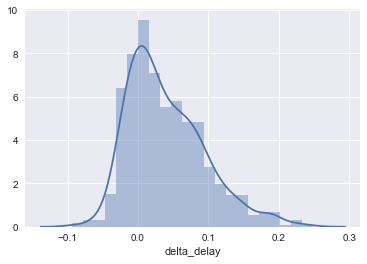

In [10]:
sns.distplot(airport_operations_df['delta_delay'])

That looks great.  The peak of the distribution is right around 0% delay change. 

In [11]:
airport_operations_df['delta_delay'].describe()

count    841.000000
mean       0.039999
std        0.054574
min       -0.093200
25%       -0.000800
50%        0.028600
75%        0.074200
max        0.249000
Name: delta_delay, dtype: float64

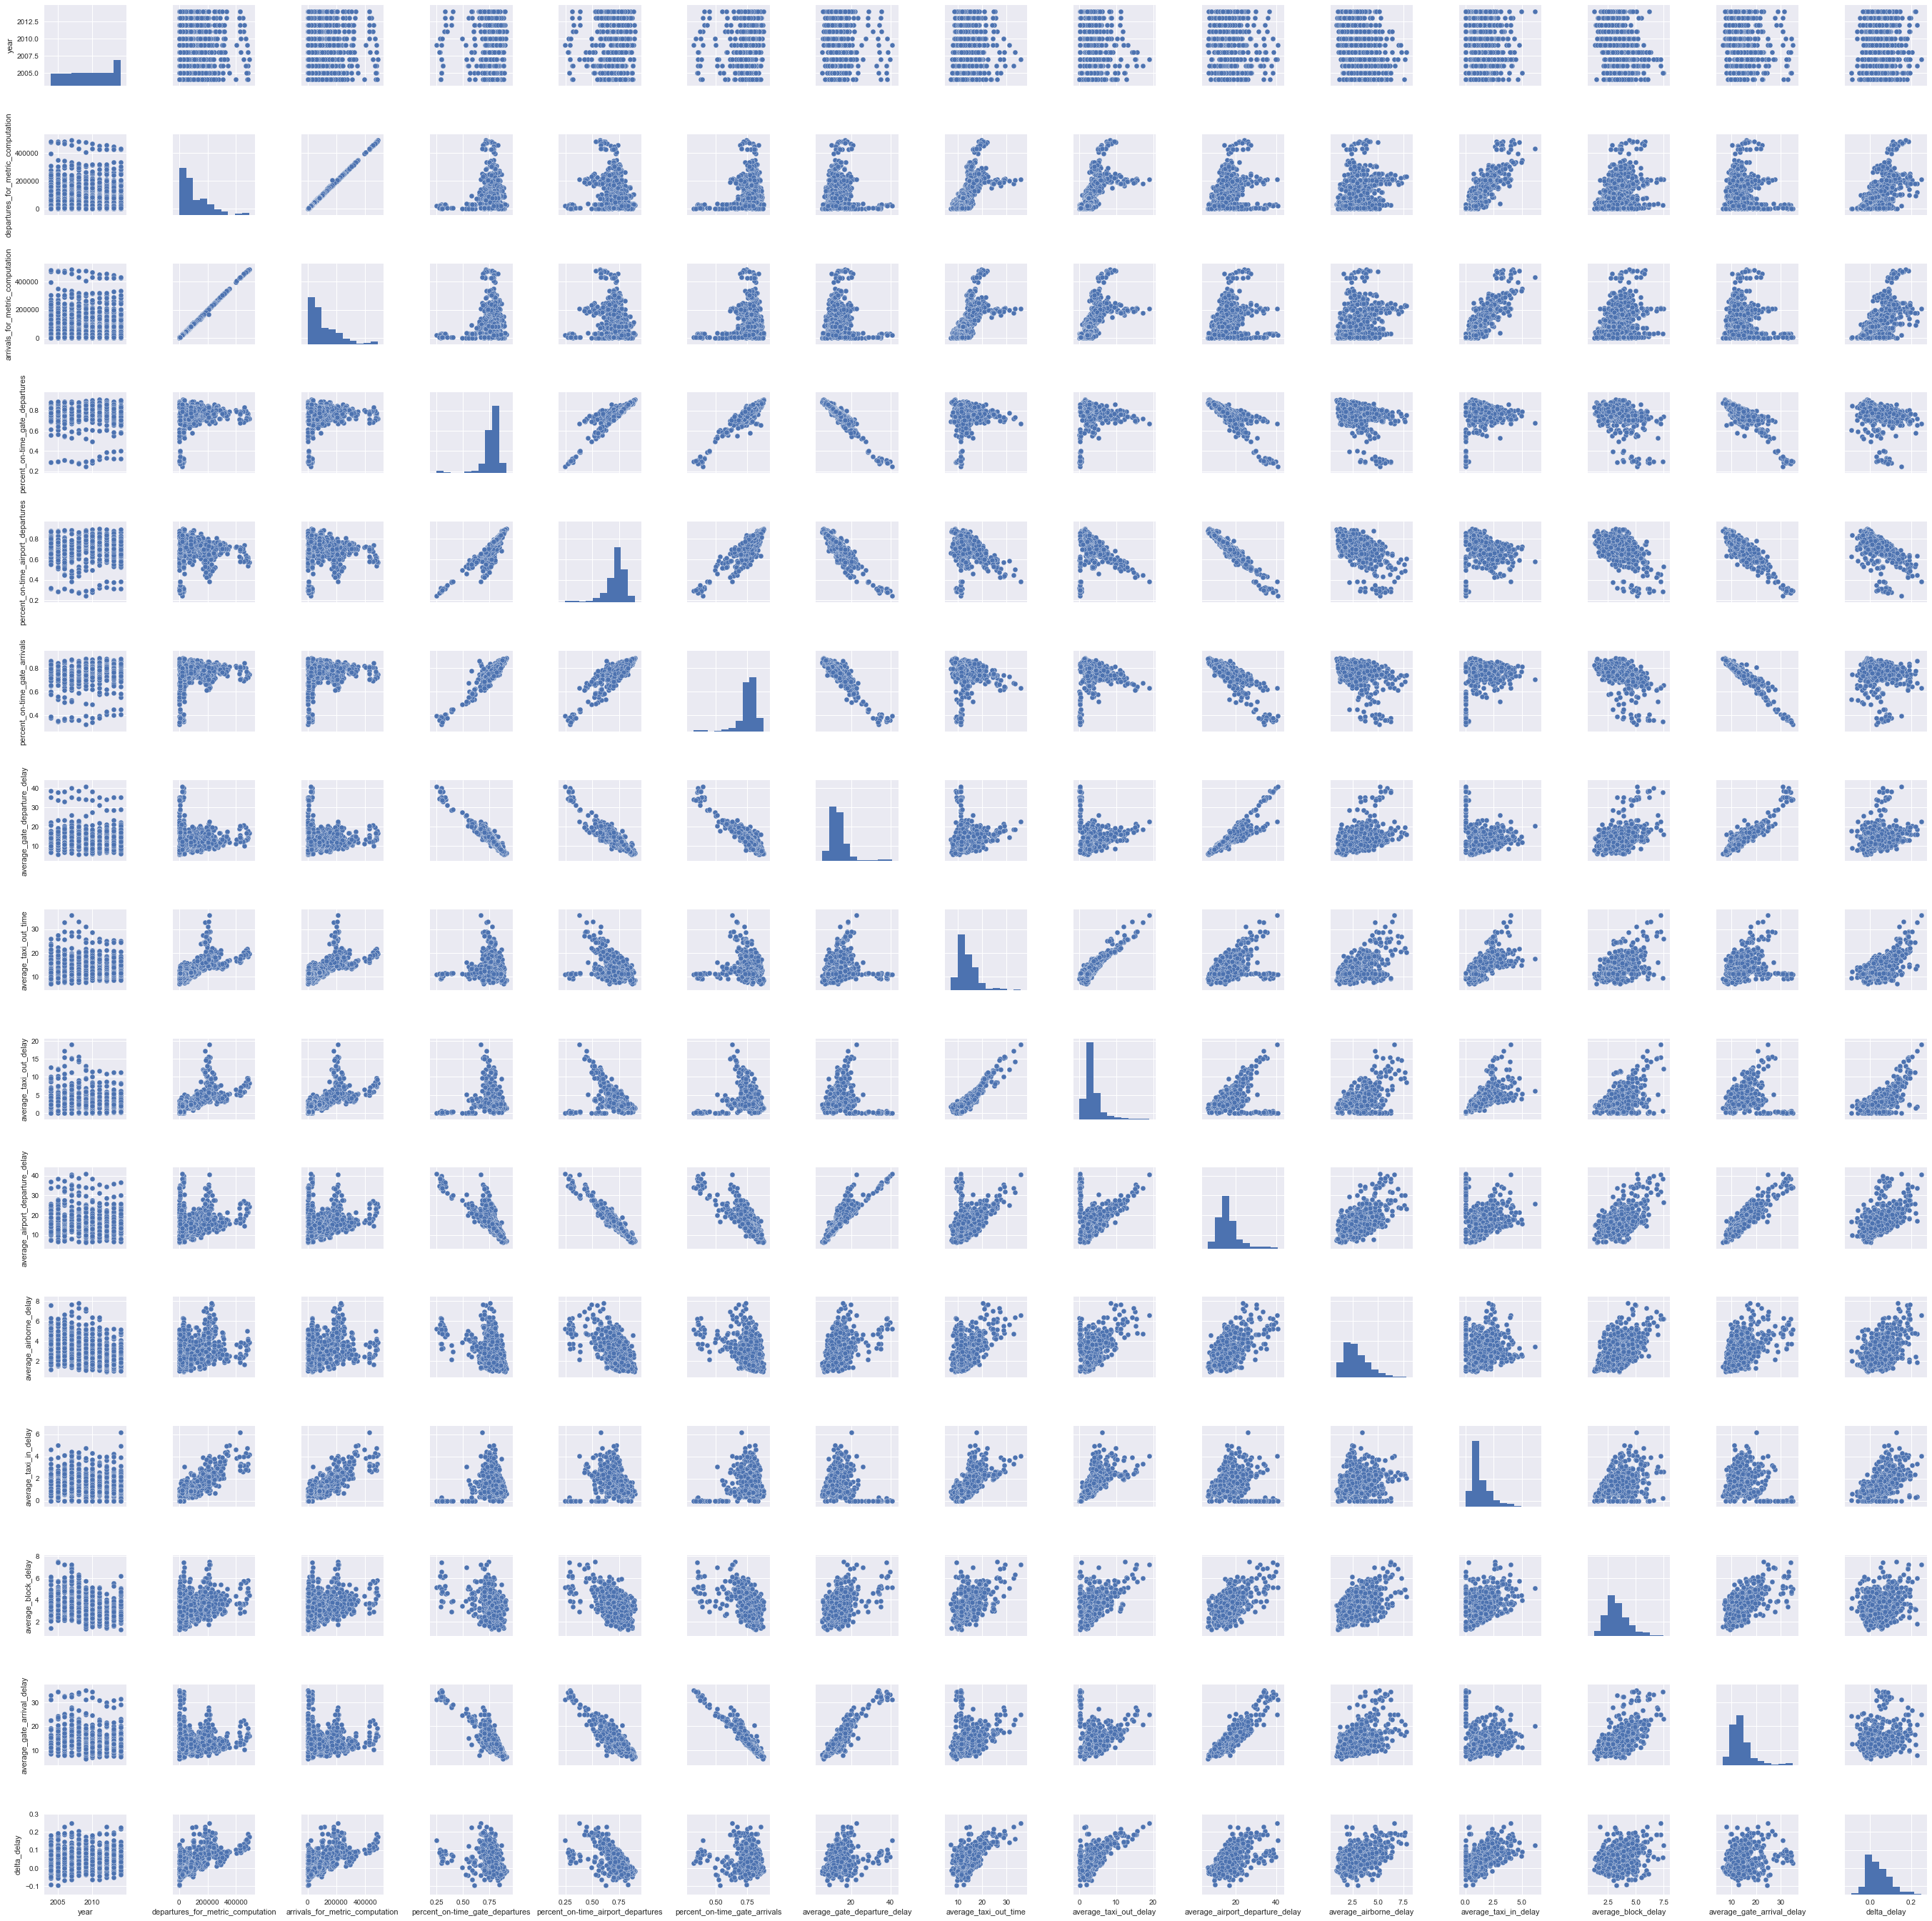

In [12]:
sns.pairplot(airport_operations_df)

There are 2 features that show distinct clusters when plotted against 'delta delay'.  These features are "average_gate_arrival_delay" and  "departures_for_metric_computation".  

Also a number of features appear to be highly colinear.  These pairs are (departures_for_metric_computation & arrivals_for_metric_computation), 
(percent_on-time_gate_arrivals & percent_on-time_airport_departures) and a few others.  If needed one half of the colinear pairs can dropped.  Initially, 'arrivals_for_metric_computation' will be dropped because it is almost perfectly paired with departures_for_mertic_computation'.

In [13]:
delays_df = airport_operations_df.drop('arrivals_for_metric_computation', axis = 1)
annual_df = airport_operations_df.groupby('airport', as_index=False)['departures_for_metric_computation']
annual_df.mean().head()                                        

,airport,departures_for_metric_computation
0,ABQ,44830.454545
1,ANC,67627.545455
2,ATL,469004.000000
3,AUS,53456.000000
4,BDL,45903.090909


There are airports that should be dismissed for a variety of reasons.  There are five airports that average less than 30 flight per day (GYY, OXR, RFD, SWF, VNY).  Tetterboro (TEB) can't host commerical traffic. If other airports should be eliminated from this analysis, thelist will be extended here:


In [14]:
traffic_summary_df = pd.merge(annual_df.mean(), 
                              airports_df[['locid','ap_name','state','ap_type']], 
                              how='left',left_on='airport', right_on='locid')
traffic_summary_df[traffic_summary_df['departures_for_metric_computation'] <10950]

,airport,departures_for_metric_computation,locid,ap_name,state,ap_type
22,GYY,534.727273,GYY,GARY/CHICAGO INTL,IN,Federalized/Commercial
50,OXR,1277.272727,OXR,OXNARD,CA,Public Use
59,RFD,6021.818182,RFD,CHICAGO/ROCKFORD INTL,IL,Federalized/Commercial
72,SWF,6060.363636,SWF,STEWART INTL,NY,Federalized/Commercial
76,VNY,4724.545455,VNY,VAN NUYS,CA,Public Use


In [15]:
traffic_summary_df[traffic_summary_df['locid'] == 'TEB']

,airport,departures_for_metric_computation,locid,ap_name,state,ap_type
73,TEB,26787.0,TEB,TETERBORO,NJ,Public Use


In [16]:
delays_df['labels'] = delays_df['airport'].str.cat(delays_df['year'].astype('str'))
delays_df = delays_df[delays_df.airport != 'GYY']
delays_df = delays_df[delays_df.airport != 'OXR']
delays_df = delays_df[delays_df.airport != 'RFD']
delays_df = delays_df[delays_df.airport != 'SWF']
delays_df = delays_df[delays_df.airport != 'VNY']
delays_df = delays_df[delays_df.airport != 'TEB']


In [17]:
delays_df.drop(['airport','year'], axis=1,inplace = True)
delays_df.set_index('labels',drop=True, inplace=True, )
delays_df.index.name = None


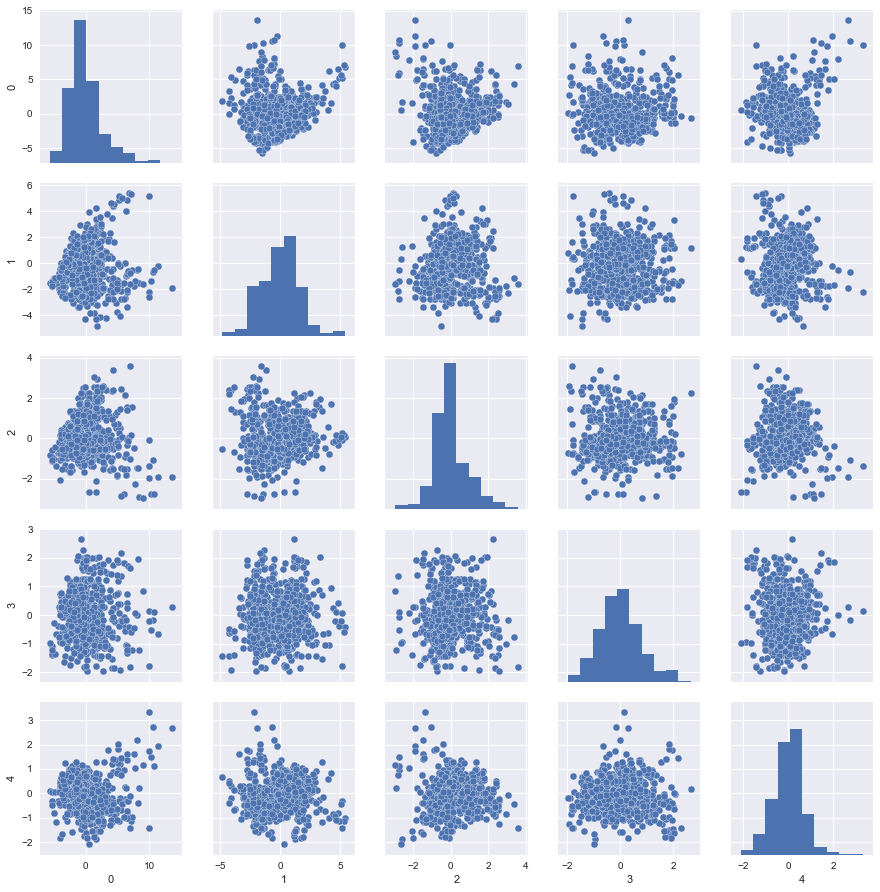

In [18]:
scale = StandardScaler()
y = delays_df['delta_delay']
X = delays_df.drop('delta_delay', axis =1)
X_scaled = scale.fit_transform(X)
pca = PCA(n_components=5)
plotable_df = pd.DataFrame(pca.fit_transform(X_scaled,y))
sns.pairplot(plotable_df)

In [19]:
pca.explained_variance_ratio_

array([ 0.58062311,  0.21326253,  0.07022196,  0.05208163,  0.03607715])

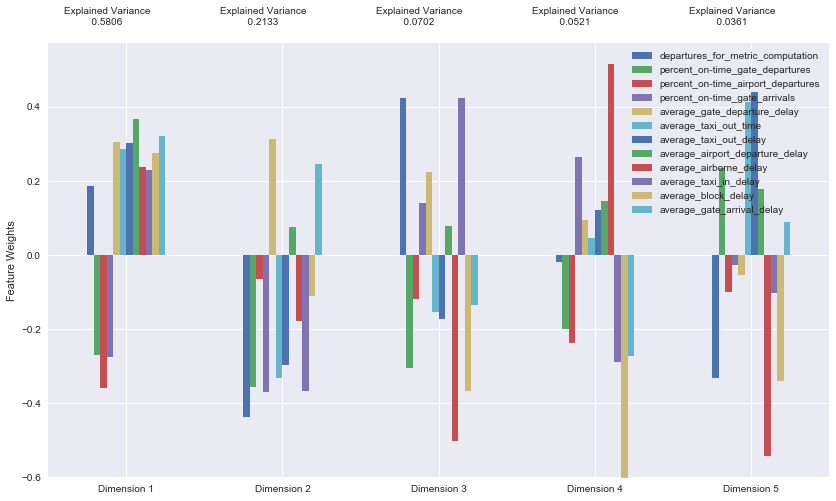

In [20]:
pca_results = rs.pca_results(X, pca)

TO DO later: repeat with grouped by airports, averaged over years.

Repeat the analysis dropping some colinear features.

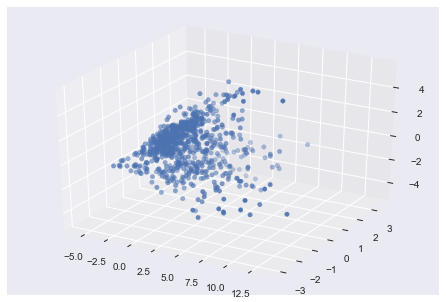

In [21]:
fig = plt.figure()
my_axes = Axes3D(fig)
my_axes.scatter3D(plotable_df[0],
                  plotable_df[2],
                  plotable_df[1])

In [22]:
X.columns

Index([u'departures_for_metric_computation',
       u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')

In [23]:
X2= X.drop(['percent_on-time_gate_departures',
            'percent_on-time_airport_departures',
            'percent_on-time_gate_arrivals'],
           axis=1)

In [24]:
scale2 = StandardScaler()
X2_scaled = scale2.fit_transform(X2)

In [25]:
pca2 = PCA(n_components=4)
pca2.fit_transform(X2_scaled)

array([[-2.20665808, -0.15351906, -0.30369388, -0.09661856],
       [-2.56402885, -0.43575922, -0.22709122, -0.13078801],
       [-2.14927833,  0.13848436, -0.03957425,  0.11071673],
       ..., 
       [-2.9640504 , -0.61770645, -0.26650566,  0.1994626 ],
       [-2.22432533,  0.29976855, -0.01627063,  0.12365873],
       [-1.6412931 ,  0.93760108,  0.29832167,  0.1054956 ]])

In [26]:
pca2.explained_variance_ratio_

array([ 0.59082453,  0.18735275,  0.08444929,  0.05703244])

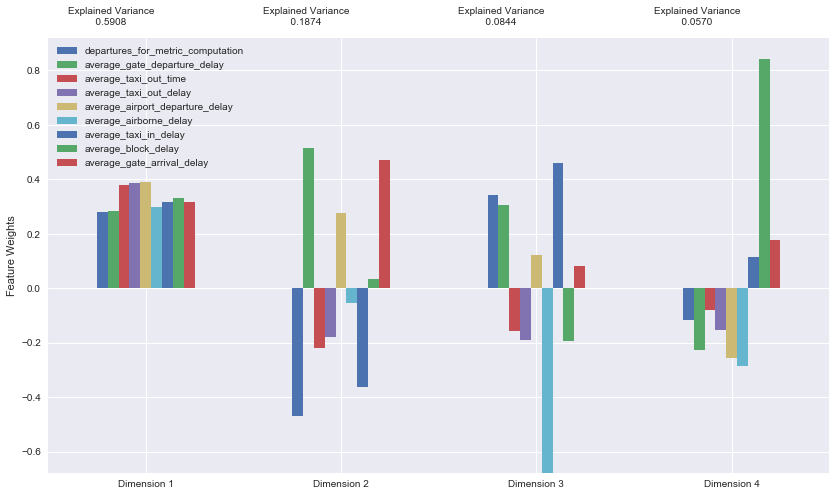

In [27]:
pca2_results = rs.pca_results(X2, pca2)

Dropping the "Percent_on-time..." features didn't significantly improve explained variance in the first 2 PCA features. Further analysis will be done with incorporating these features.

### Tsne:


In [28]:
temp3 = '5, 3, 23'
for i in range(1,5):
    for j in range(1,5):
        vec = "; {} {} {}".format(i/23., j/3.4, j**.3*i**.5)
        temp3 += vec
temp3 = np.matrix(temp3)

tsn = TSNE(n_components=3)
tsn.fit_transform(temp3)

array([[ -1.28315219e-04,   2.27164548e-04,   1.03176037e-04],
       [ -3.41523102e-05,  -8.95494180e-05,  -4.05129850e-05],
       [  8.26182895e-05,  -6.96036031e-05,   1.72346821e-05],
       [ -8.64774685e-05,   8.32256409e-05,   5.13603618e-05],
       [ -7.99446854e-05,   8.37997056e-05,  -5.63938986e-05],
       [  1.03880944e-05,   1.05675223e-04,   1.81184931e-05],
       [ -1.27940090e-04,  -9.95034655e-06,  -9.59411276e-06],
       [ -5.54101107e-05,  -1.06853666e-04,  -1.50625512e-05],
       [ -1.10984156e-05,  -1.51556020e-04,   4.18604061e-05],
       [  8.21191948e-05,  -3.03719248e-06,   3.03578750e-05],
       [  2.84411154e-05,   5.41495001e-05,  -7.66225666e-05],
       [ -9.12986388e-05,  -1.10812107e-04,   1.76799690e-04],
       [ -7.36490187e-05,  -5.52044403e-05,   1.17820232e-04],
       [ -4.57018179e-05,  -1.58717848e-04,  -1.05930178e-04],
       [  9.67415087e-05,  -4.33551176e-05,   1.47125301e-05],
       [ -2.57396769e-05,  -1.54768334e-05,  -2.0413058

In [29]:
temp3 = plotable_df.as_matrix()

In [30]:
type(temp3)

numpy.ndarray

In [31]:
tsn = TSNE(n_components=3)
tsne_results = tsn.fit_transform(X_scaled,y=y)

In [47]:
tsne_results = pd.DataFrame(tsne_results, columns=['tsne1','tsne2','tsne3'])

In [45]:
def y_hue(x):
    global y
    if x < y.mean() + 2*y.std():
        return 'red'
    else:
        return 'blue'

In [40]:
y.reset_index(drop=True,inplace=True)

In [48]:
tsne_results =tsne_results.join(y,how = 'inner')

In [49]:
tsne_results['delta_delay'] = tsne_results['delta_delay'].apply(y_hue)

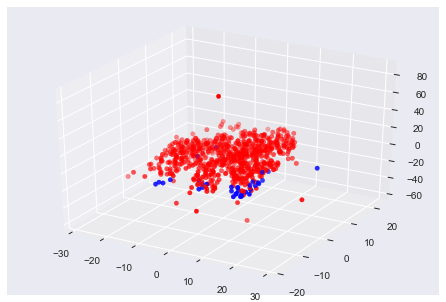

In [50]:
fig = plt.figure()
my_axes = Axes3D(fig)
my_axes.scatter3D(tsne_results['tsne1'],
                  tsne_results['tsne2'],
                  tsne_results['tsne3'], 
                 c= tsne_results['delta_delay'])

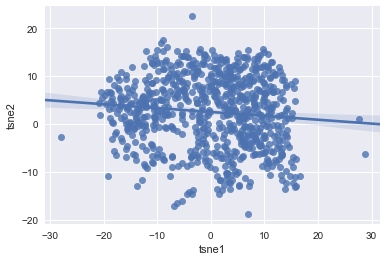

In [54]:
sns.regplot(tsne_results['tsne1'],tsne_results['tsne2'])

Repeat with information information for years.  Just checking for obvious annual trends.

In [ ]:
year_summary_df = (airport_operations_df
                      .drop('airport',axis=1)
                      .groupby('year',as_index=False).mean())

In [ ]:
year_summary_df

Repeat with information information for airport averaged across years.  The initial pca indicated years were not significant

In [ ]:
airport_summary_df = airport_operations_df.drop('year',axis=1).groupby('airport',as_index=False).mean()

In [ ]:
airport_summary_df.head()